In [153]:
import requests
from openai import AzureOpenAI
import os
import json
from pprint import pprint
from pprint import pprint
# dotenv
from dotenv import load_dotenv

if "OPENAI_API_KEY" in os.environ:
    os.environ.pop("OPENAI_API_KEY")
if "OPENAI_ENDPOINT" in os.environ:
    os.environ.pop("OPENAI_ENDPOINT")
if "AI_SEARCH_SERVICE" in os.environ:
    os.environ.pop("AI_SEARCH_SERVICE")
if "AI_SEARCH_KEY" in os.environ:
    os.environ.pop("AI_SEARCH_KEY")
if "AI_SEARCH_INDEX_NAME" in os.environ:
    os.environ.pop("AI_SEARCH_INDEX_NAME")
load_dotenv()
os.environ['AI_SEARCH_INDEX_NAME']='demo-ai-search'
ai_search_service = os.environ['AI_SEARCH_SERVICE']
ai_search_key = os.environ['AI_SEARCH_KEY']
cosmos_link = os.environ['COSMOS_LINK']
cosmos_key = os.environ['COSMOS_KEY']
cosmos_db_name = 'faqdemo'
cosmos_container_name = 'faqdemo'



In [154]:
client = AzureOpenAI(
    api_key=os.environ['OPENAI_API_KEY'],
    azure_endpoint=os.environ['OPENAI_ENDPOINT'],
    api_version="2024-02-01"
)
print(os.environ['OPENAI_ENDPOINT'])

https://aash-openai-eastus2.openai.azure.com/


In [155]:
# send a query to the AI Search service
service_name = os.environ['AI_SEARCH_SERVICE']
index_name = os.environ['AI_SEARCH_INDEX_NAME']
api_version = '2023-11-01'
api_key = os.environ['AI_SEARCH_KEY']
print(f"index_name: {index_name}")
print(f"service_name: {service_name}")
endpoint = f'https://{service_name}.search.windows.net/indexes/{index_name}/docs/search?api-version={api_version}'



index_name: demo-ai-search
service_name: ai-search-aash-demo


In [156]:
# Create a new index
service_name = os.environ['AI_SEARCH_SERVICE']
name = os.environ['AI_SEARCH_INDEX_NAME']
url = f"https://{service_name}.search.windows.net/indexes/{name}?api-version=2023-11-01"
payload = json.dumps({
  "name": name,
  "fields": [
    {
      "name": "id", # the name of the field
      "type": "Edm.String", # the data type of the field
      "searchable": False, # whether the field is searchable. This determines whether the field is included in full-text searches.
      "filterable": True, # whether the field is filterable. This determines whether the field can be used in filter expressions.
      "retrievable": True, # whether the field is retrievable. This determines whether the field is included in search results.
      "sortable": False, # whether the field is sortable. This determines whether the field can be used in order-by expressions.
      "facetable": False, # whether the field is facetable. This determines whether the field can be used in facet expressions.
      "key": True, # whether the field is a key field. This determines whether the field uniquely identifies documents in the index.
      "indexAnalyzer": None, # the name of the analyzer used at indexing time for the field
      "searchAnalyzer": None, # the name of the analyzer used at search time for the field
      "analyzer": None, # the name of the analyzer used at both indexing and search time for the field
      "fields": [] # a list of sub-fields for complex fields like collections
    },
    {
      "name": "answer",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": "en.microsoft",
      "fields": []
    },
    {
      "name": "AnswerVector",
      "type": "Collection(Edm.Single)",
      "searchable": True,
      "retrievable": True,
      "dimensions": 1536,
      "vectorSearchProfile": "my-vector-profile"
    },
    {
      "name": "filename",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    },
    {
      "name": "title",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    },
    {
      "name": "url",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    },
    {
      "name": "Tags",
      "type": "Collection(Edm.String)",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": False,
      "facetable": True,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    }
],
  "corsOptions": {
    "allowedOrigins": [
      "*"
    ],
    "maxAgeInSeconds": 60
  },
  "vectorSearch": {
      # https://learn.microsoft.com/en-us/azure/search/vector-search-overview
    "algorithms": [
      {
        "name": "my-hnsw-config",
        "kind": "hnsw",
        "hnswParameters": {
          "m": 4, # the number of bi-directional links created for each element during construction
          "efConstruction": 400, # the size of the dynamic list for the nearest neighbors (used during construction)
          "efSearch": 500, # the size of the dynamic list for the nearest neighbors (used during search)
          "metric": "cosine" # the distance metric used to compute the similarity between vectors
        }
      },
      {
        "name": "my-eknn-config",
        "kind": "exhaustiveKnn",
        "exhaustiveKnnParameters": {
          "metric": "cosine"
        }
      }
    ],
    "profiles": [
      {
        "name": "my-vector-profile",
        "algorithm": "my-hnsw-config"
      }
    ]
  },
  "semantic": {
    "configurations": [
      {
        "name": "my-semantic-config",
        "prioritizedFields": {
          "prioritizedContentFields": [
            {
              "fieldName": "answer"
            }
          ],
          "prioritizedKeywordsFields": [
            {
              "fieldName": "Tags"
            }
          ]
        }
      }
    ]
  }
})
headers = {
  'Content-Type': 'application/json',
  'api-key': os.environ['AI_SEARCH_KEY']
}

response = requests.request("PUT", url, headers=headers, data=payload)



In [157]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexerClient
from azure.search.documents.indexes.models import (
    SearchIndexerDataSourceConnection,
    SearchIndexer,
    FieldMapping
)
from azure.cosmos import CosmosClient
search_indexer_client = SearchIndexerClient(endpoint=f"https://{ai_search_service}.search.windows.net",
                                            credential=AzureKeyCredential(ai_search_key))
cosmos_client = CosmosClient(cosmos_link, cosmos_key)
data_source_name = "cosmosdb-datasource"
data_source_connection = SearchIndexerDataSourceConnection(
    name=data_source_name,
    type="cosmosdb",
    connection_string=f"AccountEndpoint={cosmos_link};AccountKey={cosmos_key};Database={cosmos_db_name};",
    container={"name": cosmos_container_name}
)
# Check if the data source already exists and create or update accordingly
try:
    existing_data_source = search_indexer_client.get_data_source_connection(data_source_name)
    search_indexer_client.create_or_update_data_source_connection(data_source_connection)
    print(f"Updated data source connection: {data_source_name}")
except Exception as e:
    search_indexer_client.create_data_source_connection(data_source_connection)
    print(f"Created new data source connection: {data_source_name}")

    # Define field mappings
field_mappings = [
    FieldMapping(source_field_name="id", target_field_name="id"),
    FieldMapping(source_field_name="answer", target_field_name="answer"),
    FieldMapping(source_field_name="AnswerVector", target_field_name="AnswerVector"),
    FieldMapping(source_field_name="title", target_field_name="title"),
    FieldMapping(source_field_name="url", target_field_name="url"),
    FieldMapping(source_field_name="file_name", target_field_name="filename")
]

# Create the Indexer

indexer_name = "cosmosdb-indexer"
# delete indexer if exists
try:
    search_indexer_client.delete_indexer(indexer_name)
    print(f"Deleted existing indexer: {indexer_name}")
except Exception as e:
    pass

indexer = SearchIndexer(
    name=indexer_name,
    data_source_name=data_source_name,
    target_index_name=index_name,
    field_mappings=field_mappings,
    schedule={"interval": "PT5M"}  # Every 5 minutes

)
search_indexer_client.create_indexer(indexer)

print("Search index, data source, and indexer created successfully.")



Updated data source connection: cosmosdb-datasource
Deleted existing indexer: cosmosdb-indexer
Search index, data source, and indexer created successfully.


In [130]:
# uploading the data
import importlib
import ai_search_upload_data
importlib.reload(ai_search_upload_data)

# Re-import the functions after reloading the module
from ai_search_upload_data import analyze_and_upload_docs, analyze_and_updload_images

# analyze the documents
docs = analyze_and_upload_docs()
print(f"docs: {docs}")
# analyze the images
images_urls = ["https://new2cloud.de/wp-content/uploads/2021/04/CreateAzureFreeAccount-1-1536x879.png"]
images = analyze_and_updload_images(images_urls)
print("Done")

https://aash-openai-eastus2.openai.azure.com/
https://aash-openai-eastus2.openai.azure.com/
Index name: demo-netrefer
Service name: ai-search-aash-demo
Analyzing doc 6cd1d749-9c92-4fae-88a6-c3cd207617b8
Analyzing doc d0a2b90d-2bae-4bd8-be57-84ee27fb6e1e
Analyzing doc 56579dee-87d9-4287-b016-5dd9d7396c70
Analyzing doc 08dcf272-4f33-4f93-af32-542db6cdeedd
Analyzing doc 751fa012-eb69-426e-b1a7-a493a4667fd2
Analyzing doc 3739281f-c56f-4fd7-b57d-25b156b01a6e
Analyzing doc 368cfc1f-d2d6-47c9-81ca-f75adf2541a7
Analyzing doc 26dc8d02-f889-43f8-b298-e9638c7baea5
Analyzing doc ed2f86cc-bde7-427a-8177-82f736e51c93
Analyzing doc 30f0d35f-246f-4f88-9e69-14ad008a5968
Analyzing doc 6737c8c9-021f-43fb-95a8-8022c6fb881e
Analyzing doc 80376320-5f96-41ac-8dd4-65289e197093
Analyzing doc fdb52865-8b0e-4f5a-b7d3-ddc5dafb5dad
Analyzing doc 8b1a3ae6-57d1-49f0-9110-11cdc7312707
Analyzing doc 4d547217-a47e-4fb6-b9bf-a657fba7cfb1
Analyzing doc 6fa2d76d-4d91-4ae1-a1ae-0c7b12687e02
Analyzing doc b93f6b1a-c0ca-49bc

In [132]:
def get_embedding(text, model="text-embedding-ada-002"):
    response = client.embeddings.create(input=text,
    model=model)
    return response.data[0].embedding

In [133]:
def build_payload_keyword_search(user_query, top=3):
    return json.dumps({
        "count": True,
        "search": user_query,
        "select": "id, answer, Tags",
        "top": top
    })

def answer_question_keyword(user_query):
    payload = build_payload_keyword_search(user_query)
    headers = {
      'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]

In [134]:
def build_payload_vector_search(user_query, k=7):
    return json.dumps({
        "count": True, # return the count of results
        "select": "id, answer, Tags", # return the specified fields
        "vectorQueries": [
            {
                "vector": get_embedding(user_query, model="text-embedding-ada-002"),
                "k": k, # k is the number of results to return
                "fields": "AnswerVector",
                "kind": "vector",
                "exhaustive": True
            }
        ]
    })

def answer_question_vector(user_query):
    payload = build_payload_vector_search(user_query, 3)
    headers = {
      'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]

In [135]:
def build_payload_hybrid_search(user_query, k=3, top=3):
    return json.dumps({
        "count": True,
        "search": user_query,
        "select": "id, answer, Tags, filename",
        "top": top,
        "vectorQueries": [
            {
                "vector": get_embedding(user_query, model="text-embedding-ada-002"),
                "k": k,
                "fields": "AnswerVector",
                "kind": "vector",
                "exhaustive": True
            }
        ]
    })

def answer_question_hybrid(user_query):
    payload = build_payload_hybrid_search(user_query)
    headers = {
      'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]

In [136]:
def build_payload_hybrid_search_semantic(user_query, k=3, top=3):
    return json.dumps({
        "count": True,
        "search": user_query,
        "queryType": "semantic",  # Enable semantic search
        "semanticConfiguration": "my-semantic-config",  # Apply the semantic configuration
        "select": "id, answer, Tags, filename",
        "top": top,
        "vectorQueries": [
            {
                "vector": get_embedding(user_query, model="text-embedding-ada-002"),
                "k": k,
                "fields": "AnswerVector",
                "kind": "vector",
                "exhaustive": True
            }
        ]
    })

def answer_question_hybrid_semantic(user_query):
    payload = build_payload_hybrid_search(user_query)
    headers = {
        'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]


In [137]:
# API end point
question = "Can I skip the 30 days and just start with pay-as-you-go pricing?"
prompt = "Q: " + question + "\nA:"
prompt = "I am searching for information about the question in 3 modes: keyword, vector, and hybrid search. Here are the results:\n\n"
res_keyword = answer_question_keyword(question)
prompt += "Keyword search:\n"
for r in res_keyword:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    print(r["answer"])
    print(r["Tags"])
    print(r["@search.score"])
    print(r["id"])
    print()
prompt+= "----end of keyword search----\n\n"

At the end of your first 30 days or after you spend your $200 credit (whichever comes first), we'll ask you if you want to move to pay-as-you-go pricing. If you move to pay as you go, you'll keep getting free services and you'll only pay for what you use beyond the free monthly amounts. If you don't move to pay as you go, you can't purchase Azure services beyond your $200 credit—and eventually your account and services will be disabled.
['FAQ', 'Azure']
10.974613
368cfc1f-d2d6-47c9-81ca-f75adf2541a7

You start getting monthly free amounts of more than 55 other services when you create your Azure free account. If you move to pay-as-you-go pricing after 30 days or after you use your credit, you’ll continue to receive monthly free amounts of these services. If you exceed your monthly free amounts for any of these services, you’ll be billed for them at pay-as-you-go rates.
['FAQ', 'Azure']
5.626695
d0a2b90d-2bae-4bd8-be57-84ee27fb6e1e

When you sign up for an Azure free account, you get $2

In [138]:
res_vector = answer_question_vector(question)
prompt += "Vector search:\n"
for r in res_vector:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    print(f"answer: {r['answer']}")
    print(r["@search.score"])
    print()
prompt+= "----end of vector search----\n\n"



answer: If you decide not to move to pay-as-you-go pricing after your first 30 days or once you've used up your $200 credit (whichever happens first), any services you've deployed will be decommissioned and you won't be able to access them. To regain access, move to pay as you go within the following 30 days.
0.8904743

answer: Yes. You can sign up directly for pay as you go. This will enable you to immediately use services beyond the free amounts at pay-as-you-go rates. You'll still get monthly free amounts of popular services for 12 months and more than 55 services that are always free, but you won't receive the $200 credit.
0.88990515

answer: Once you move to pay-as-you-go pricing, certain types of popular services are available in free monthly amounts for 12 months. If you're using any of these services after 12 months, they'll continue to run and you'll be billed at pay-as-you-go rates. You'll continue to receive monthly free amounts of more than 55 services that are always free.

In [139]:
res_hybrid = answer_question_hybrid(question)
prompt += "Hybrid search:\n"

for r in res_hybrid:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    print(f"answer: {r['answer']}")
    print(f"filename: {r['filename']}")
    print(f"Tags: {r['Tags']}")
    print(f"score: {r['@search.score']}")
    print(f"id: {r['id']}")
    print()
prompt+= "----end of hybrid search----\n\n"

answer: If you decide not to move to pay-as-you-go pricing after your first 30 days or once you've used up your $200 credit (whichever happens first), any services you've deployed will be decommissioned and you won't be able to access them. To regain access, move to pay as you go within the following 30 days.
filename: faqs.csv
Tags: ['FAQ', 'Azure']
score: 0.03181818127632141
id: 6737c8c9-021f-43fb-95a8-8022c6fb881e

answer: Yes. You can sign up directly for pay as you go. This will enable you to immediately use services beyond the free amounts at pay-as-you-go rates. You'll still get monthly free amounts of popular services for 12 months and more than 55 services that are always free, but you won't receive the $200 credit.
filename: faqs.csv
Tags: ['FAQ', 'Azure']
score: 0.03109932318329811
id: 26dc8d02-f889-43f8-b298-e9638c7baea5

answer: Once you move to pay-as-you-go pricing, certain types of popular services are available in free monthly amounts for 12 months. If you're using any

In [140]:
res_semantic = answer_question_hybrid_semantic(question)
prompt += "Hybrid search with semantic search:\n"
for r in res_semantic:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    pprint(r)
    print(f"answer: {r['answer']}")
    print(r["@search.score"])
    print()
prompt+= "----end of hybrid search with semantic search----\n\n"


{'@search.score': 0.03181818127632141,
 'Tags': ['FAQ', 'Azure'],
 'answer': 'If you decide not to move to pay-as-you-go pricing after your '
           "first 30 days or once you've used up your $200 credit (whichever "
           "happens first), any services you've deployed will be "
           "decommissioned and you won't be able to access them. To regain "
           'access, move to pay as you go within the following 30 days.',
 'filename': 'faqs.csv',
 'id': '6737c8c9-021f-43fb-95a8-8022c6fb881e'}
answer: If you decide not to move to pay-as-you-go pricing after your first 30 days or once you've used up your $200 credit (whichever happens first), any services you've deployed will be decommissioned and you won't be able to access them. To regain access, move to pay as you go within the following 30 days.
0.03181818127632141

{'@search.score': 0.03109932318329811,
 'Tags': ['FAQ', 'Azure'],
 'answer': 'Yes. You can sign up directly for pay as you go. This will enable '
           

In [141]:


prompt += """which of the methods do you think is the best that gave the most relevant results? 
rank them from 1 to 4 and explain the results\n\n"""

response = client.chat.completions.create(
    model="gpo-4o-global",
    messages=[
        {"role": "system", "content": prompt}
    ],  
    max_tokens=1000,
)
print()
print(response.choices[0].message.content)


Based on the provided information, here is a ranking of the search methods from most relevant to least relevant, along with an explanation for each:

### 1. **Hybrid Search with Semantic Search**
- **Explanation:** This method provided the most contextually relevant answers and clear information regarding the scenario of what happens after the $200 credit is exhausted or after the first 30 days. The answers directly addressed the specific situation and provided detailed consequences, such as services being decommissioned and options to regain access, which aligns closely with the expected results.

### 2. **Hybrid Search**
- **Explanation:** The hybrid search also provided highly relevant results with similar comprehensive detail to the hybrid search with semantic search. The slight difference and reason it ranks second is that it doesn't employ the semantics layer which refines and possibly enhances contextual understanding.

### 3. **Vector Search**
- **Explanation:** This method de

In [142]:
question = "what are the services included in the Microsoft Azure free trial offer?"
answer_hybrid = answer_question_hybrid(question)

# pprint(f"hybrid={answer_hybrid}")
for answer in answer_hybrid:
    print(answer["Tags"])
    print(answer["@search.score"])
    print(answer["id"])
    print()

['FAQ', 'Azure', 'Image']
0.03306011110544205
1a41acbb-4006-401e-89eb-8bf77202b685

['FAQ', 'Azure', 'Image']
0.03306011110544205
b64e70a0-b6dd-4da8-812e-0e6158db897b

['FAQ', 'Azure']
0.03021353855729103
d0a2b90d-2bae-4bd8-be57-84ee27fb6e1e



In [143]:
# putting images in the answer example


prompt = f"""the user question: {question}
The following data was retrieved from the Azure Search service:
"""
for answer in answer_hybrid:
    prompt += "----------------\n"
    prompt += f"""{answer["answer"]}\n"""
    if "Image" in answer["Tags"]:
        print(f"answer: {answer['Tags']}")
        prompt += f"""image_url: {answer["filename"]}"""
    prompt += "\n"
prompt += "----------------\n"
print(prompt)
response = client.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        messages=[
            {
                "role": "system",
                "content": """you are a bot that answers questions about Azure services
                                write an answer to the user. The answer can combine images and text. The answer should be informative and concise. answer shortly and only about what the user asked.
                                format the answer in a json structure with the following format:
                                {"answer": [
                                    {
                                        "type": "text",
                                        "content": <>
                                    },
                                    {
                                        "type": "image",
                                        "url": <>,
                                        "caption": <>
                                    }....
                                ]}
                                when integrating image into the answer, add text before the image that will explain what can be seen in the image. for exaple: In the following image, you can see....
                                the message will print the information in order of the list and will present the images from the urls."""
            }, {
                "role": "user",
                "content": prompt
            }
        ]
    )
# make sure that we take only the json by finding the first { and last } chars
res_json_str = response.choices[0].message.content[response.choices[0].message.content.find("{"):response.choices[0].message.content.rfind("}")+1]
res_json = json.loads(res_json_str)
pprint(res_json)


answer: ['FAQ', 'Azure', 'Image']
answer: ['FAQ', 'Azure', 'Image']
the user question: what are the services included in the Microsoft Azure free trial offer?
The following data was retrieved from the Azure Search service:
----------------
The image is an overview of the Microsoft Azure free trial services, providing details on various available services and their respective capacities. It includes services under different categories such as compute, storage, databases, networking, integration, and containers. Specific services listed include Linux Virtual Machines, Windows Virtual Machines, Managed Disks, Blob Storage, File Storage, SQL Database, VPN Gateway, Load Balancer, Azure Cosmos DB, Service Bus, Container Registry, and Archive Storage. Each service is accompanied by a specific quota or limit, such as 750 hours for virtual machines, 64 GB for managed disks, 5 GB for blob and file storage, and 250 GB for SQL Database. Additionally, new services highlighted include VPN Gateway, L

The Microsoft Azure free trial includes a variety of services across different categories such as Compute, Storage, Databases, Networking, Integration, and Containers. Specific services provided under the free trial offer include Linux and Windows Virtual Machines, Managed Disks, Blob Storage, File Storage, SQL Database, VPN Gateway, Load Balancer, Azure Cosmos DB, Service Bus, Container Registry, and Archive Storage. Each service comes with specific quotas or limits.

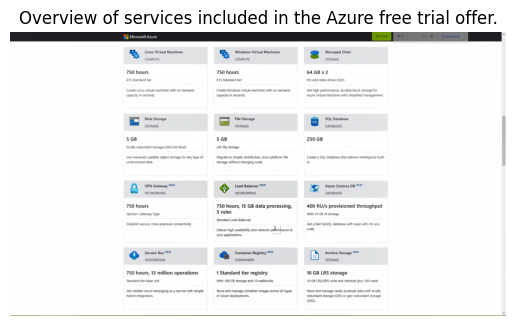

Apart from the initial offerings, after creating your Azure free account, you also receive monthly free amounts of over 55 other services. If you continue with a pay-as-you-go pricing after 30 days or upon using your initial credit, you still receive free amounts monthly for these services. Charges apply only when you exceed these free limits.

In [144]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display, Markdown


def display_response(response):
    for item in response['answer']:
        if item['type'] == 'text':
            display(Markdown(item['content']))
        elif item['type'] == 'image':
            response = requests.get(item['url'])
            img = Image.open(BytesIO(response.content))
            plt.imshow(img)
            plt.axis('off')
            plt.title(item['caption'])
            plt.show()

# Call the function to display the response
display_response(res_json)
